## First attack

Берутся N транзакций у пользователя. Значения выборки заменяются на максимальные/минимальные значения допустимых транзакций (границы определены в quantiles)

In [1]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from model import predict # Функция, позволяет получить предсказание нейронки.
from check_budget import check_budget # функция проверки бюджета. Проверяйте допустимость решения до сабмита
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

bins_path = "nn_bins.pickle" # путь до файла с бинами после тренировки модели (nn_bins.pickle)
model_path = "nn_weights.ckpt" # путь до файла с весами нейронной сети (nn_weights.ckpt)
quantiles_path = "quantiles.json" # путь до файла с квантилями для таргета (quantiles.pickle)

output_path = "naive_submission.csv" # куда сохранить атакованные транзакции
transactions_path = "../sample_submission.csv"    # путь до файла с транзакциями, которые атакуются

train_data_path = "../transactions_finetune.csv" # X - train data
train_target_path = "../target_finetune.csv" # y - true target

In [2]:
seed = 26041999
BUDGET = 10 # разрешенное количество изменений транзакций для каждого пользователя - N транзакций
threshold = pd.read_csv(train_target_path).target.mean() # примерный threshold трейна

In [3]:
# у нас нет разметки для тех транзакций, которые мы атакуем - но у нас есть модель.
# Давайте посчитаем вероятность того, что пользователь принадлежит к классу 1
result = predict(transactions_path, bins_path, model_path, random_seed=seed)
result.head()

Global seed set to 26041999


,user_id,target
0,66,0.027909
1,213,0.019507
2,345,0.162300
3,569,0.084853
4,573,0.016584


In [4]:
result['target_true'] = result.target.apply(lambda x: 0 if x <= threshold else 1)
result

,user_id,target,target_true
0,66,0.027909,0
1,213,0.019507,0
2,345,0.162300,1
3,569,0.084853,1
4,573,0.016584,0
...,...,...,...
4195,868183,0.016348,0
4196,868407,0.046630,1
4197,868573,0.037443,1
4198,868694,0.016083,0


In [5]:
roc_auc_score(result.target_true, result.target)

1.0

In [6]:
random.seed(seed)

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)
df_transactions.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,66,5812,48,-1842.949000,2021-05-17 11:30:42
1,66,4112,48,-283.283720,2021-05-17 12:59:02
2,66,5814,48,-73.820390,2021-05-17 14:04:09
3,66,4111,48,10.971557,2021-05-17 15:03:10
4,66,7991,48,-214.796420,2021-05-17 15:33:43


In [7]:
df = df_transactions.merge(result, how='left', on='user_id')
df

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,target_true
0,66,5812,48,-1842.949000,2021-05-17 11:30:42,0.027909,0
1,66,4112,48,-283.283720,2021-05-17 12:59:02,0.027909,0
2,66,5814,48,-73.820390,2021-05-17 14:04:09,0.027909,0
3,66,4111,48,10.971557,2021-05-17 15:03:10,0.027909,0
4,66,7991,48,-214.796420,2021-05-17 15:33:43,0.027909,0
...,...,...,...,...,...,...,...
1259995,868873,5533,48,-458.109830,2021-06-27 09:25:53,0.007286,0
1259996,868873,5411,48,-257.352540,2021-06-29 07:00:31,0.007286,0
1259997,868873,5921,48,-446.213780,2021-06-30 02:26:42,0.007286,0
1259998,868873,5411,48,-261.241580,2021-06-30 11:34:35,0.007286,0


In [8]:
# границы допустимых решений.

with open(quantiles_path, 'r') as f:
    quantiles = json.load(f)

quantiles["positive"]["min"]["5411"], quantiles["positive"]["max"]["5411"]

(0.90168, 36819.70001)

In [9]:
# последние 10 транзакций каждого пользователя
# df_attack = pd.DataFrame()
# for user in df.user_id.unique():
#     df1 = df.loc[df.user_id == user][-BUDGET:]
#     df_attack = pd.concat([df_attack, df1])
# df_attack

In [11]:
# случайные 10 транзакций каждого пользователя
df_attack = pd.DataFrame()
for user in df.user_id.unique():
    df1 = df.loc[df.user_id == user].sample(BUDGET)
    df_attack = pd.concat([df_attack, df1])
df_attack

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,target_true
223,66,5941,48,-226.942030,2021-07-03 14:10:09,0.027909,0
68,66,4112,48,-651.410800,2021-05-26 17:28:17,0.027909,0
35,66,5812,48,-655.366150,2021-05-19 11:35:10,0.027909,0
151,66,4131,48,-22.070593,2021-06-13 05:09:34,0.027909,0
254,66,5921,48,-121.310470,2021-07-14 17:06:08,0.027909,0
...,...,...,...,...,...,...,...
1259874,868873,5944,48,-21339.248000,2021-04-27 04:31:56,0.007286,0
1259962,868873,5921,48,-464.578220,2021-05-30 05:47:58,0.007286,0
1259953,868873,5912,48,-1291.254800,2021-05-27 04:15:29,0.007286,0
1259811,868873,5533,48,-1258.042800,2021-03-19 12:02:14,0.007286,0


In [12]:
uniq_mcc = df_attack.mcc_code.unique()
uniq_mcc[:10]

array([5941, 4112, 5812, 4131, 5921, 6011, 5411, 4121, 5977, 6012])

In [14]:
# первая атака. из случайной выборки df_attack транзакции заменяются значениями границ, подходящих по mcc коду
# quantiles["positive"]["min"]["5411"], quantiles["positive"]["max"]["5411"]
for mcc in uniq_mcc:
    # if negative (нет дефолта)
    if df_attack.loc[(df_attack.target_true == 0)
                     & (df_attack.transaction_amt < 0)
                     & (df_attack.mcc_code == mcc)].shape[0]:

        df_attack.loc[(df_attack.target_true == 0)
                      & (df_attack.transaction_amt < 0)
                      & (df_attack.mcc_code == mcc), 'transaction_amt'] = quantiles["negative"]["min"][f"{mcc}"]+0.0001

    if df_attack.loc[(df_attack.target_true == 0)
                     & (df_attack.transaction_amt > 0)
                     & (df_attack.mcc_code == mcc)].shape[0]:

        df_attack.loc[(df_attack.target_true == 0)
                      & (df_attack.transaction_amt > 0)
                      & (df_attack.mcc_code == mcc), 'transaction_amt'] = quantiles["positive"]["min"][f"{mcc}"]+0.0001

    # if positive (дефолт)
    if df_attack.loc[(df_attack.target_true == 1)
                     & (df_attack.transaction_amt < 0)
                     & (df_attack.mcc_code == mcc)].shape[0]:

        df_attack.loc[(df_attack.target_true == 1)
                      & (df_attack.transaction_amt < 0)
                      & (df_attack.mcc_code == mcc), 'transaction_amt'] = quantiles["negative"]["max"][f"{mcc}"]-0.0001

    if df_attack.loc[(df_attack.target_true == 1)
                     & (df_attack.transaction_amt > 0)
                     & (df_attack.mcc_code == mcc)].shape[0]:

        df_attack.loc[(df_attack.target_true == 1)
                      & (df_attack.transaction_amt > 0)
                      & (df_attack.mcc_code == mcc), 'transaction_amt'] = quantiles["positive"]["max"][f"{mcc}"]-0.0001

In [15]:
df_attack

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,target_true
223,66,5941,48,-207989.999910,2021-07-03 14:10:09,0.027909,0
68,66,4112,48,-56682.233910,2021-05-26 17:28:17,0.027909,0
35,66,5812,48,-188727.312400,2021-05-19 11:35:10,0.027909,0
151,66,4131,48,-90525.234275,2021-06-13 05:09:34,0.027909,0
254,66,5921,48,-124302.649910,2021-07-14 17:06:08,0.027909,0
...,...,...,...,...,...,...,...
1259874,868873,5944,48,-177666.139910,2021-04-27 04:31:56,0.007286,0
1259962,868873,5921,48,-124302.649910,2021-05-30 05:47:58,0.007286,0
1259953,868873,5912,48,-176347.249910,2021-05-27 04:15:29,0.007286,0
1259811,868873,5533,48,-199745.906150,2021-03-19 12:02:14,0.007286,0


In [16]:
df_attack.index.value_counts()

223        1
839844     1
839732     1
839757     1
839804     1
          ..
420056     1
420278     1
420013     1
420091     1
1259836    1
Length: 42000, dtype: int64

In [20]:
# attack
df_transactions.update(df_attack)

In [21]:
df_transactions.loc[df_transactions.user_id == 66][-10:]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
290,66.0,5411.0,48.0,-946.00690,2021-07-24 10:48:11
291,66.0,5411.0,48.0,-569.09454,2021-07-25 08:29:13
292,66.0,7216.0,48.0,-167.91891,2021-07-25 13:27:45
293,66.0,5411.0,48.0,-451.44680,2021-07-25 13:36:52
294,66.0,5814.0,48.0,-236.72583,2021-07-26 11:42:22
295,66.0,5816.0,48.0,-140.88486,2021-07-27 11:46:23
296,66.0,5411.0,48.0,-1025.03200,2021-07-29 13:39:39
297,66.0,5411.0,48.0,-2331.80660,2021-07-31 13:32:14
298,66.0,5815.0,48.0,-681.92970,2021-08-01 05:29:15
299,66.0,5411.0,48.0,-408.48978,2021-08-06 14:09:21


In [22]:
output_path = 'first_attack.csv'
df_transactions.to_csv(output_path, index=False)

In [23]:
# ROC-AUC Diff
def roc_auc_diff(attacked_path, transactions_path, threshold=None):
    result = predict(transactions_path, bins_path, model_path, random_seed=seed)
    attacked = predict(output_path, bins_path, model_path, random_seed=seed)

    if not threshold:
        threshold = pd.read_csv(train_target_path).target.mean() # примерный threshold трейна

    target_attack = attacked.rename(columns={'target': 'target_attack'})
    target_attack['target_pred_true'] = result.target
    target_attack['target_true'] = result.target.apply(lambda x: 0 if x <= threshold else 1)

    roc_auc_orig = roc_auc_score(target_attack.target_true, target_attack.target_pred_true)
    roc_auc_attack = roc_auc_score(target_attack.target_true, target_attack.target_pred_true) -\
                     roc_auc_score(target_attack.target_true, target_attack.target_attack)
    print('ROC-AUC original', roc_auc_orig)
    print('ROC-AUC attacked', roc_auc_score(target_attack.target_true, target_attack.target_attack))
    print('DIF ROC-AUC', roc_auc_attack)
    return target_attack

In [24]:
target_attack = roc_auc_diff(output_path, transactions_path, threshold=threshold)

Global seed set to 26041999
Global seed set to 26041999


ROC-AUC original 1.0
ROC-AUC attacked 0.9999903356646684
DIF ROC-AUC 9.664335331560636e-06


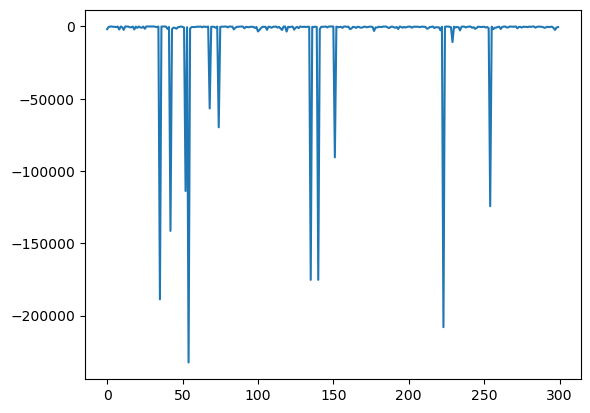

In [37]:
plt.plot(range(300), df_transactions.loc[df_transactions.user_id == 66].transaction_amt.values)

In [24]:
check_budget(transactions_path, output_path, quantiles_path) # Не забываем проверять бюджет перед самбитом!

100%|█████████████████████████████████████████████████████████████████████| 1260000/1260000 [00:33<00:00, 37877.43it/s]


True